In [1]:
# Set MPS fallback to enable operations not supported natively on Apple Silicon
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import bopt
import h5py as h5

In [2]:
sample_rate = 50
device = bopt.cuda_init()  # Using specific GPU
# device='cuda:7'
samplerate = 50
num_before = 25
num_after = 5
seed = 2222
torch.random.manual_seed(seed)

--- device:0 has 1
--- device:1 has 1
--- device:2 has 3
--- device:3 has 1
--- device:4 has 1
--- device:5 has 1
--- device:6 has 0
--- device:7 has 0
Selected device: cuda:6


# In this notebook, we will sketch out code for shifting stimulus according to eye position on the fly.
The rough procedure is as follows:
1. Get the current eye position from the eye tracker.
2. Adapt the stimulus shifting pipeline to shift the stimulus based on the current eye position.
3. Return the shifted stimulus.

In [3]:
# Let's first load the h5 and see what's inside
h5_filepath = '/home/sunnyliu1220/sean_data/charm_50_rec.h5'
charmander_clusters= [ 4, 15, 41, 42, 43, 50, 62, 107, 121, 168, 225, 226, 245, 251, 259, 261,
    263, 271, 282, 294, 302, 327, 334, 340, 342, 347, 363, 364, 367, 375, 400,
    555
]

with h5.File(h5_filepath, 'r') as f:
    # Print the keys in the file
    print("Keys in the h5 file:", list(f.keys()))
    # Explore the first level of the hierarchy for each key
    for key in f.keys():
        print(f"Subkeys under '{key}':", list(f[key].keys()))
    # Explore the second level of the hierarchy for each subkey
    # 'meta'
    print("cluster_ids:", f['meta']['cluster_ids'][:])
    # Print the reconstruction
    reconstruction = f['meta']['reconstruction']
    # This is a "Group" object, we need to explore its keys
    print("Keys in 'reconstruction':", list(reconstruction.keys()))
    # Let's print the first few items in the reconstruction
    for subkey in reconstruction.keys():
        try:
            print(f"Subkey '{subkey}':", reconstruction[subkey][:])
        except Exception as e:
            print(f"Subkey '{subkey}':", reconstruction[subkey][()])

    # Now, let's check the 'data' key
    data = f['data']
    print("Keys in 'data':", list(data.keys()))
    # Check 'series_001'
    series_001 = data['series_001']
    print("Keys in 'series_001':", list(series_001.keys()))
    # Check 'epoch_001'
    epoch_001 = series_001['epoch_001']
    print("Keys in 'epoch_001':", list(epoch_001.keys()))
    print("Attributes of 'epoch_001':", dict(epoch_001.attrs))
    # Check the stimulus
    stimulus = epoch_001['stimulus']
    print("Keys in 'stimulus':", list(stimulus.keys()))
    # Check the 'shifted' key. Print its shape
    shifted = stimulus['shifted']
    print("Shape of 'shifted':", shifted.shape)
    # Check the 'static' key
    static = stimulus['static']
    print("Shape of 'static':", static.shape)
    # Check the 'signals' key
    signals = epoch_001['signals']
    print("Keys in 'signals':", list(signals.keys()))

Keys in the h5 file: ['data', 'meta']
Subkeys under 'data': ['series_001', 'series_002', 'series_003', 'series_004', 'series_005', 'series_006', 'series_007', 'series_008', 'series_009']
Subkeys under 'meta': ['cluster_ids', 'reconstruction']
cluster_ids: [  0   3   4   5   8  10  13  14  15  17  19  21  22  23  24  27  30  31
  33  35  37  38  39  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  56  57  61  62  64  72  74  79  84 106 107 118 121 124 125 129 134
 135 136 140 143 145 146 153 154 159 160 163 166 167 168 169 172 173 174
 175 176 177 178 180 183 186 188 189 190 191 195 198 200 205 206 207 209
 211 225 226 227 231 232 235 237 240 245 246 247 250 251 253 255 259 261
 263 271 272 276 278 279 280 281 282 284 286 287 289 294 297 298 300 301
 302 303 304 306 307 309 314 315 316 319 326 327 328 330 334 339 340 341
 342 345 346 347 348 351 357 360 363 364 367 368 369 373 375 377 378 379
 380 381 384 385 386 387 389 390 391 394 400 426 428 513 515 529 554 555
 556 557 559 5

In [28]:
direction='shifted'
test_series = ['series_008/epoch_001', 'series_009/epoch_001']
test_idxs = [-samplerate * 10, -1]
test_all = [0, -1]

test_dataset_shifted = bopt.CorticalDataset(h5_filepath,
                                    test_series,
                                    num_before=num_before,
                                    num_after=num_after,
                                    start_idx=test_all[0],
                                    end_idx=test_all[1],
                                    stimulus_key='shifted',
                                    grayscale=True,
                                    normalize_signals=False,
                                    signals=['locomotion', 'azimuth'],
                                    which_clusters=charmander_clusters,
                                    zero_blinks=True)

test_loader_shifted = torch.utils.data.DataLoader(test_dataset_shifted,
                                          batch_size=256,
                                          shuffle=False)



Zeroing out blinks in stimulus (at init).
Zeroing out blinks in stimulus (at init).
Zeroing out blinks in stimulus (at init).


Shape of the first frame: torch.Size([30, 68, 102])


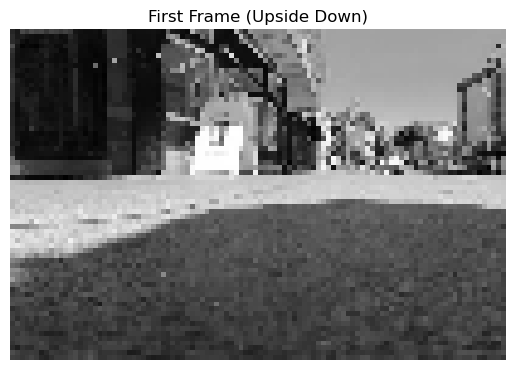

In [29]:
# Let's visualize the first frame of data as an image, flipped upside down
frame = test_dataset_shifted[200][0]
print("Shape of the first frame:", frame.shape)
plt.imshow(frame[20].flip(0), cmap='gray')
plt.title("First Frame (Upside Down)")
plt.axis('off')
plt.show()

In [30]:
# Visualize the second series in test_series
direction='shifted'
test_series = ['series_009/epoch_001']
test_idxs = [-samplerate * 10, -1]
test_all = [0, -1]

test_dataset_shifted = bopt.CorticalDataset(h5_filepath,
                                    test_series,
                                    num_before=num_before,
                                    num_after=num_after,
                                    start_idx=test_all[0],
                                    end_idx=test_all[1],
                                    stimulus_key='shifted',
                                    grayscale=True,
                                    normalize_signals=False,
                                    signals=['locomotion', 'azimuth'],
                                    which_clusters=charmander_clusters,
                                    zero_blinks=True)

test_loader_shifted = torch.utils.data.DataLoader(test_dataset_shifted,
                                          batch_size=256,
                                          shuffle=False)



Zeroing out blinks in stimulus (at init).


Shape of the first frame: torch.Size([30, 68, 102])


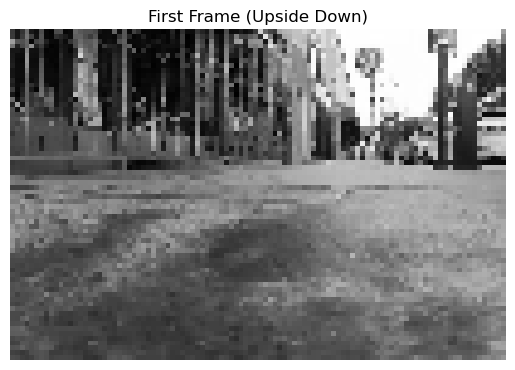

In [31]:
# Let's visualize the first frame of data as an image, flipped upside down
frame = test_dataset_shifted[200][0]
print("Shape of the first frame:", frame.shape)
plt.imshow(frame[20].flip(0), cmap='gray')
plt.title("First Frame (Upside Down)")
plt.axis('off')
plt.show()

In [13]:
# Let's modify another h5 so that it only contains the chosen series and epochs
import os
output_h5_filepath = '/home/sunnyliu1220/git/latent-gaze/data/charm_50_rec_reduced.h5'

# Remove the file if it already exists
if os.path.exists(output_h5_filepath):
    os.remove(output_h5_filepath)
    print(f"Removed existing file: {output_h5_filepath}")

# Open the output file first
with h5.File(output_h5_filepath, 'w') as f_out:
    # Then open the input file
    with h5.File(h5_filepath, 'r') as f_in:
        # Copy the metadata
        f_in.copy('meta', f_out)
        
        # Create the data group
        data_group = f_out.create_group('data')
        
        # Copy each series and epoch
        for series in test_series:
            series_key = series.split('/')[0]
            epoch_key = series.split('/')[1]
            
            # Create series group if it doesn't exist yet
            if series_key not in data_group:
                series_group = data_group.create_group(series_key)
            else:
                series_group = data_group[series_key]
            
            # Create the complete hierarchical path
            source_path = f'data/{series_key}/{epoch_key}'
            
            # Copy the data directly from the source to the destination
            f_in.copy(source_path, series_group, name=epoch_key)

# Verify the file was created and has content
with h5.File(output_h5_filepath, 'r') as f:
    print(f"File created with keys: {list(f.keys())}")
    if 'data' in f:
        print(f"Data contains series: {list(f['data'].keys())}")
    else:
        print("No data group found!")

Removed existing file: /home/sunnyliu1220/git/latent-gaze/data/charm_50_rec_reduced.h5
File created with keys: ['data', 'meta']
Data contains series: ['series_008', 'series_009']


In [14]:
# Let's verify the contents of our newly created H5 file
with h5.File(output_h5_filepath, 'r') as f:
    # Print the high-level structure
    print("Keys in the reduced h5 file:", list(f.keys()))
    
    # Check data structure
    print("\nData structure:")
    for series_key in f['data'].keys():
        print(f"  Series: {series_key}")
        for epoch_key in f['data'][series_key].keys():
            print(f"    Epoch: {epoch_key}")
            for group_key in f['data'][series_key][epoch_key].keys():
                print(f"      Group: {group_key}")
    
    # Check metadata
    print("\nMetadata structure:")
    for meta_key in f['meta'].keys():
        print(f"  {meta_key}")
    
    # Check file size
    import os
    print(f"\nFile size: {os.path.getsize(output_h5_filepath) / (1024*1024):.2f} MB")

Keys in the reduced h5 file: ['data', 'meta']

Data structure:
  Series: series_008
    Epoch: epoch_001
      Group: firing_rates
      Group: signals
      Group: stimulus
  Series: series_009
    Epoch: epoch_001
      Group: firing_rates
      Group: signals
      Group: stimulus

Metadata structure:
  cluster_ids
  reconstruction

File size: 636.14 MB


In [32]:
test_series = ['series_008/epoch_001', 'series_009/epoch_001']

In [33]:
# Visualize the second series in test_series using the new reduced H5 file
direction='shifted'
test_series = ['series_009/epoch_001']
test_idxs = [-samplerate * 10, -1]
test_all = [0, -1]

test_dataset_shifted = bopt.CorticalDataset(output_h5_filepath,
                                    test_series,
                                    num_before=num_before,
                                    num_after=num_after,
                                    start_idx=test_all[0],
                                    end_idx=test_all[1],
                                    stimulus_key='shifted',
                                    grayscale=True,
                                    normalize_signals=False,
                                    signals=['locomotion', 'azimuth'],
                                    which_clusters=charmander_clusters,
                                    zero_blinks=True)

test_loader_shifted = torch.utils.data.DataLoader(test_dataset_shifted,
                                          batch_size=256,
                                          shuffle=False)



Zeroing out blinks in stimulus (at init).


Shape of the first frame: torch.Size([30, 68, 102])


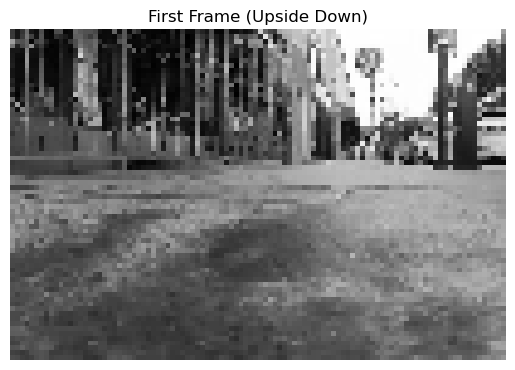

In [34]:
# Let's visualize the first frame of data as an image, flipped upside down
frame = test_dataset_shifted[200][0]
print("Shape of the first frame:", frame.shape)
plt.imshow(frame[20].flip(0), cmap='gray')
plt.title("First Frame (Upside Down)")
plt.axis('off')
plt.show()

In [35]:
# Let's write a function that shifts a stimulus by a certain number of pixels
def shift_stimulus(stimulus, dy, dx):
    """
    Shift the stimulus by a certain number of pixels. We fill in the empty pixels with zeros.
    This function shifts the stimulus in the y and x directions based on the provided dy and dx tensors.
    
    Parameters:
    - stimulus: A torch.Tensor of shape (height, width) representing the stimulus.
    - dy: The number of pixels to shift in the y direction (positive for up, negative for down). torch.Tensor of shape (N)
    - dx: The number of pixels to shift in the x direction (positive for left, negative for right). torch.Tensor of shape (N)
    Returns:
    - shifted_stimulus: A torch.Tensor of shape (N, height, width) representing the shifted stimulus.
    """
    height, width = stimulus.shape
    N = dy.shape[0]
    
    # Create an empty tensor to hold the shifted stimuli
    shifted_stimulus = torch.zeros((N, height, width), dtype=stimulus.dtype, device=stimulus.device)
    
    for i in range(N):
        # Flip the sign of the shifts
        y_shift = -dy[i].item()
        x_shift = -dx[i].item()
        
        # Calculate the new coordinates
        if y_shift >= 0:
            y_start = y_shift
            y_end = height
            y_new_start = 0
            y_new_end = height - y_shift
        else:
            y_start = 0
            y_end = height + y_shift
            y_new_start = -y_shift
            y_new_end = height
        
        if x_shift >= 0:
            x_start = x_shift
            x_end = width
            x_new_start = 0
            x_new_end = width - x_shift
        else:
            x_start = 0
            x_end = width + x_shift
            x_new_start = -x_shift
            x_new_end = width
        
        # Fill the shifted stimulus with the original stimulus values
        shifted_stimulus[i, y_new_start:y_new_end, x_new_start:x_new_end] = stimulus[y_start:y_end, x_start:x_end]
    
    return shifted_stimulus

Shape of the first frame: torch.Size([30, 68, 102])


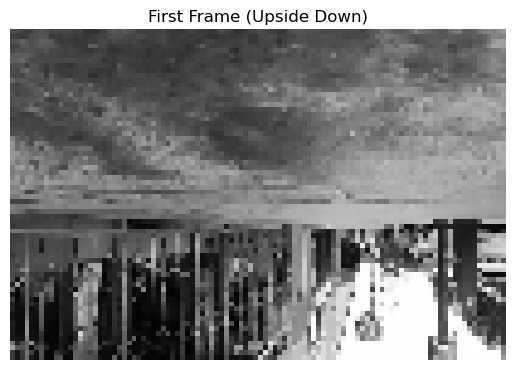

In [36]:
# Let's visualize a frame of data as an image again
frame = test_dataset_shifted[200][0]
print("Shape of the first frame:", frame.shape)
plt.imshow(frame[20], cmap='gray')
plt.title("First Frame (Upside Down)")
plt.axis('off')
plt.show()

Shape of the first frame: torch.Size([1, 68, 102])


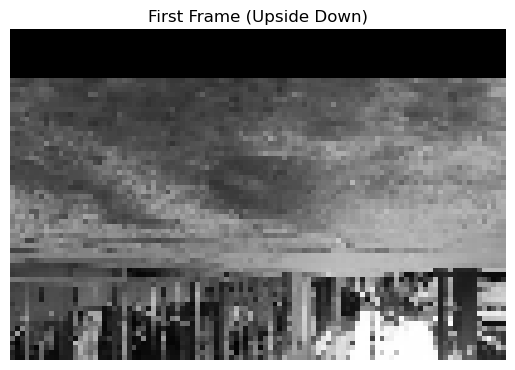

In [39]:
# Now, let's shift the stimulus by a certain number of pixels
dy = torch.tensor([10])
frame = test_dataset_shifted[200][0]
shifted_frame = shift_stimulus(frame[20], dy, torch.tensor([0]))
print("Shape of the first frame:", shifted_frame.shape)
plt.imshow(shifted_frame.squeeze(), cmap='gray')
plt.title("First Frame (Upside Down)")
plt.axis('off')
plt.show()